# Graph Link Prediction - Facebook Friend Recommendation

## Problem statement:

Given a directed social graph, we have to predict missing links to recommend friends/connnections/followers (Link Prediction in graph)

## Data Overview
Dataset from facebook's recruting challenge on kaggle: https://www.kaggle.com/c/FacebookRecruiting<br>
Data contains two columns: source and destination edge pairs in the directed graph.

- Data columns (total 2 columns):  
- source_node         int64  
- destination_node    int64  

## Mapping the problem to supervised learning problem:
- Map this to a binary classification task with 0 implying an absence of an edge and 1 implying the presence as y_i's.<br> 
- Now, we need to featurize a pair of vertices (u_i,u_j) such that these features can help us predict the presence/absence of an edge. A simple feature could be number of common-friends to u_i and u_j which is highly indicative of an edge between u_i and u_j.

- Reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

## Business objectives and constraints:
- No low-latency requirements.
- Predciting the probability of a link is useful so as to recommend the highest probability links to a user.
- We got to suggest connnections which are most likley to be correct and we should try and not miss out any connnections.

## Performance metric for supervised learning:
1. Both precision and recall are important, hence F1 score is good choice
2. Confusion matrix
3. Accuracy can also be checked

## 1. Exploratory Data Analysis

### 1.1 Reading Data

In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
import math
import csv
import random
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

plt.style.use("fivethirtyeight") 
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

In [2]:
data_raw = pd.read_csv("../Data/train.csv")
data_raw.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [3]:
print("Number of edge connections =",data_raw.shape[0])

Number of edge connections = 9437519


In [4]:
#sampling 300k data-points due to constraints in computation power
data_raw = data_raw[0:300000]
print("Number of edge connections =",data_raw.shape[0])

Number of edge connections = 300000


In [5]:
#removing columns names and index then saving the file
data_raw.to_csv("../Data/Train_New.csv", header = False, index = False)

In [6]:
#creating directed graph of whole data
G = nx.read_edgelist("../Data/Train_New.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 279652
Number of edges: 300000
Average in degree:   1.0728
Average out degree:   1.0728


### 1.2 Plotting Sub Graph

Name: 
Type: DiGraph
Number of nodes: 97
Number of edges: 75
Average in degree:   0.7732
Average out degree:   0.7732


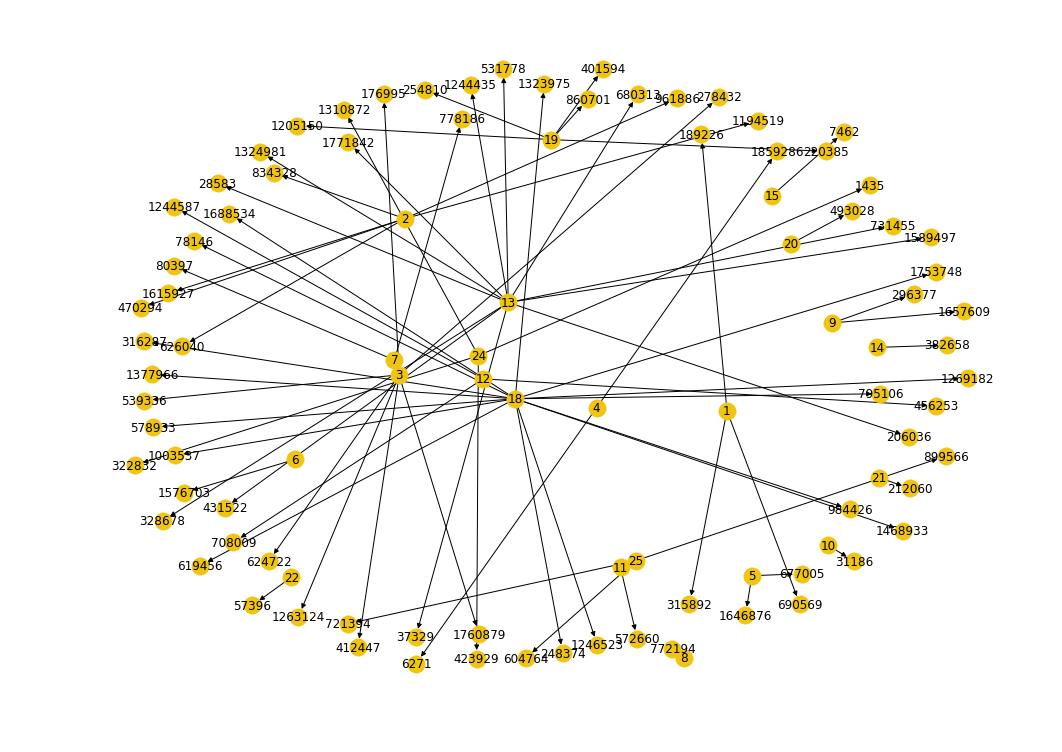

In [7]:
pd.read_csv("../Data/train.csv", nrows = 75).to_csv("../Data/Train_Sample.csv", header = False, index = False)
subGraph = nx.read_edgelist("../Data/Train_Sample.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
print(nx.info(subGraph))
plt.figure(figsize = (14, 10))
nx.draw(G = subGraph, pos = nx.spring_layout(subGraph), with_labels = True, node_color = '#F1C40F')

### 1.3 Number of unique persons

In [8]:
print("Total number of unique persons =",len(G.nodes()))

Total number of unique persons = 279652


### 1.4 Number of followers of each person (In-Degree)

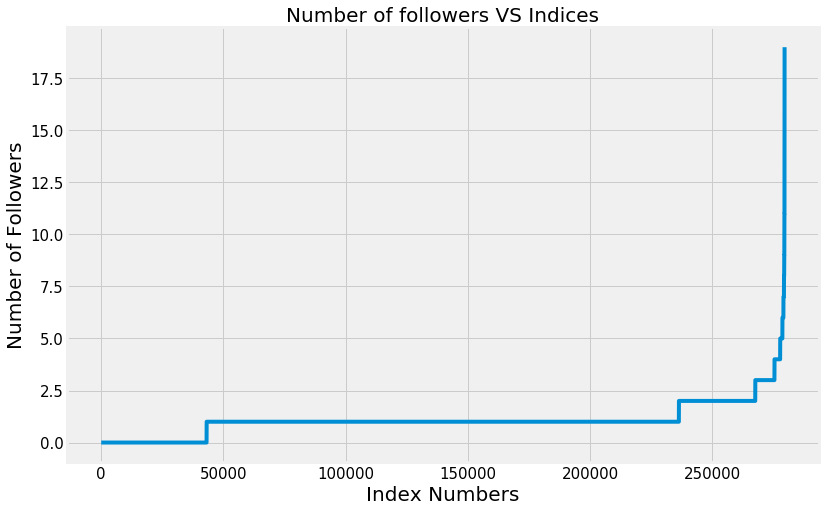

In [38]:
indegreeValues = list(dict(G.in_degree()).values())
indegreeValues.sort()
plt.figure(figsize = (12,8))
plt.title("Number of followers VS Indices")
plt.ylabel("Number of Followers")
plt.xlabel("Index Numbers")
plt.plot(indegreeValues)
plt.show()

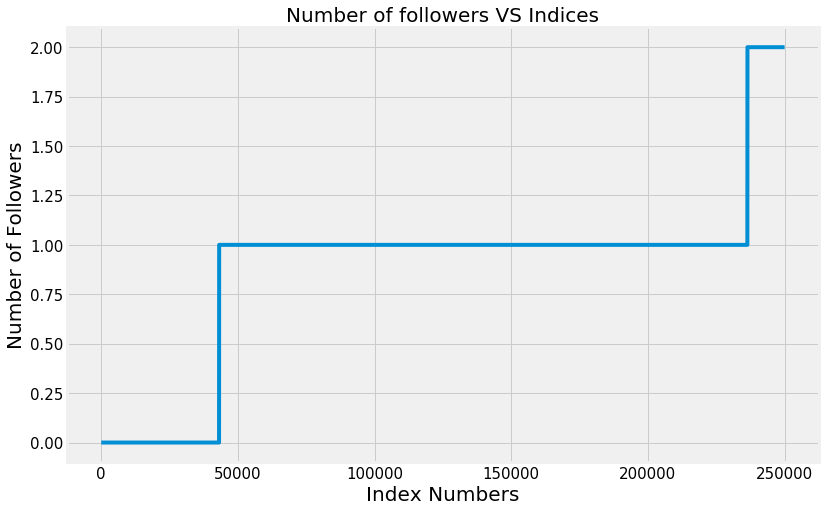

In [11]:
indegreeValues = list(dict(G.in_degree()).values())
indegreeValues.sort()
indegreeValues = indegreeValues[:250000]
plt.figure(figsize = (12,8))
plt.title("Number of followers VS Indices")
plt.ylabel("Number of Followers")
plt.xlabel("Index Numbers")
plt.plot(indegreeValues)
plt.show()

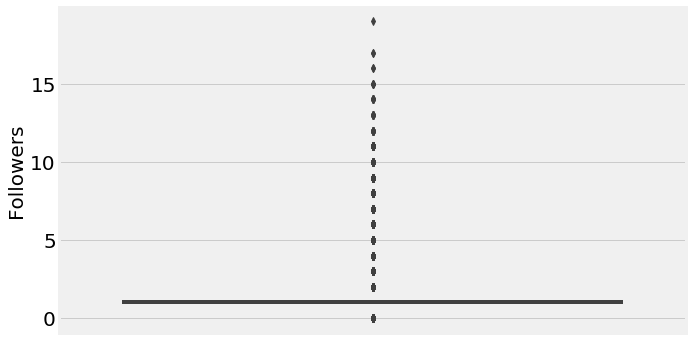

In [22]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(indegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followers", fontsize = 20)
plt.show()

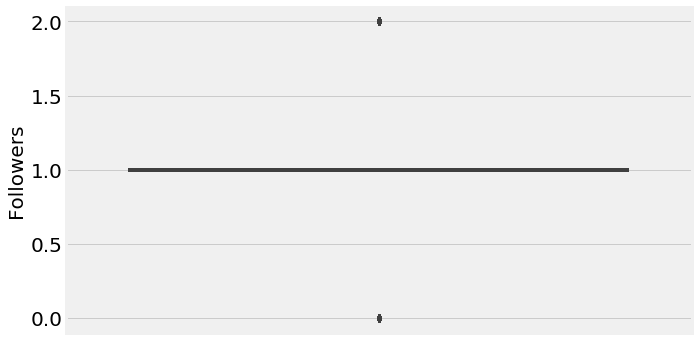

In [23]:
indegreeValues = indegreeValues[:250000]
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(indegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followers", fontsize = 20)
plt.show()

In [39]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.90, 1.01, 0.01))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

90.0th percentile value = 2.0
91.0th percentile value = 2.0
92.0th percentile value = 2.0
93.0th percentile value = 2.0
94.0th percentile value = 2.0
95.0th percentile value = 2.0
96.0th percentile value = 3.0
97.0th percentile value = 3.0
98.0th percentile value = 3.0
99.0th percentile value = 4.0
100.0th percentile value = 19.0


In [40]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.99, 1.001, 0.001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

99.0th percentile value = 4.0
99.1th percentile value = 4.0
99.2th percentile value = 4.0
99.3th percentile value = 4.0
99.4th percentile value = 5.0
99.5th percentile value = 5.0
99.6th percentile value = 5.0
99.7th percentile value = 6.0
99.8th percentile value = 6.0
99.9th percentile value = 7.0
100.0th percentile value = 19.0


In [41]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.999, 1.0001, 0.0001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 2), quantile_values[list(quantile_values.keys())[i]]))

99.9th percentile value = 7.0
99.91th percentile value = 8.0
99.92th percentile value = 8.0
99.93th percentile value = 8.0
99.94th percentile value = 9.0
99.95th percentile value = 9.0
99.96th percentile value = 9.0
99.97th percentile value = 10.0
99.98th percentile value = 11.0
99.99th percentile value = 13.0
100.0th percentile value = 18.999999999883585


Text(0.5,0,'Followers')

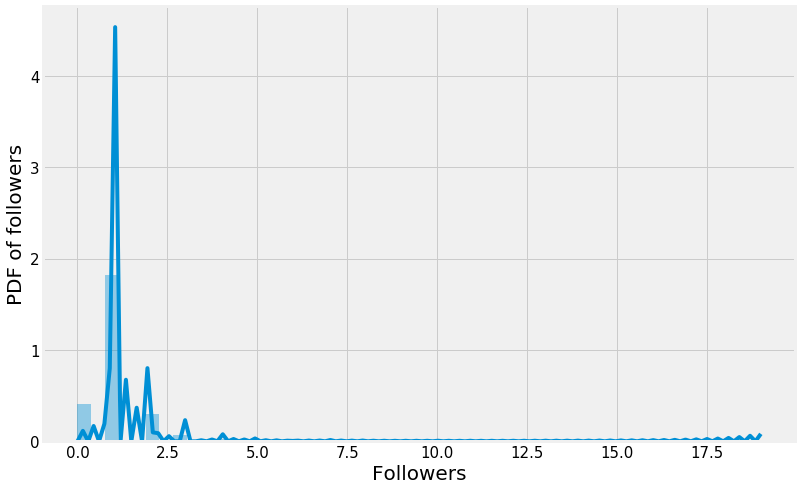

In [42]:
fig = plt.figure(figsize = (12,8))
sns.distplot(indegree_series)
plt.ylabel("PDF of followers")
plt.xlabel("Followers")

__Observation:__<br>
Above plots shows that almost 99% of people have less than 4 followers and very few people have high number of followers

### 1.5 Number of people each person is following (Out-Degree)

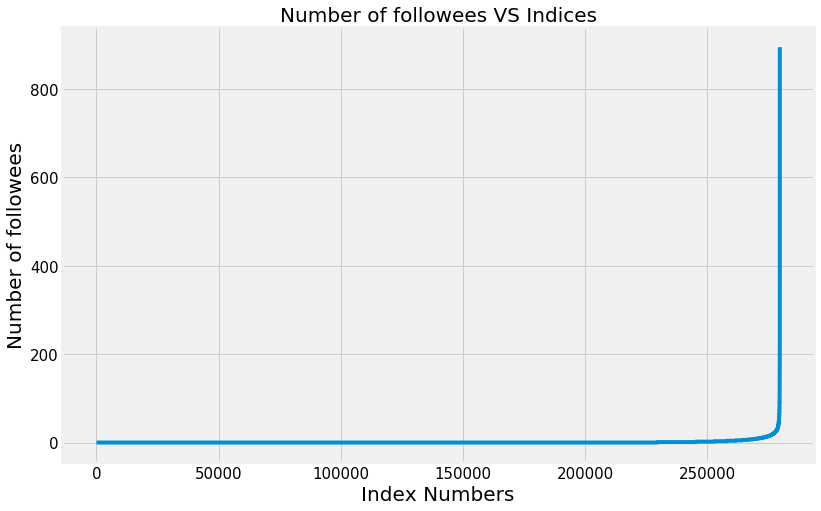

In [43]:
outdegreeValues = list(dict(G.out_degree()).values())
outdegreeValues.sort()
plt.figure(figsize = (12,8))
plt.title("Number of followees VS Indices")
plt.ylabel("Number of followees")
plt.xlabel("Index Numbers")
plt.plot(outdegreeValues)
plt.show()

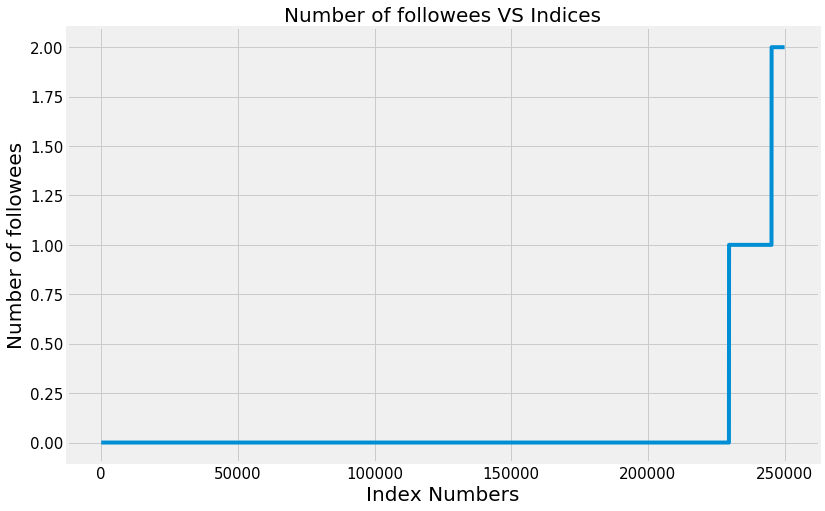

In [34]:
outdegreeValues = list(dict(G.out_degree()).values())
outdegreeValues.sort()
outdegreeValues = outdegreeValues[:250000]
plt.figure(figsize = (12,8))
plt.title("Number of followees VS Indices")
plt.ylabel("Number of followees")
plt.xlabel("Index Numbers")
plt.plot(outdegreeValues)
plt.show()

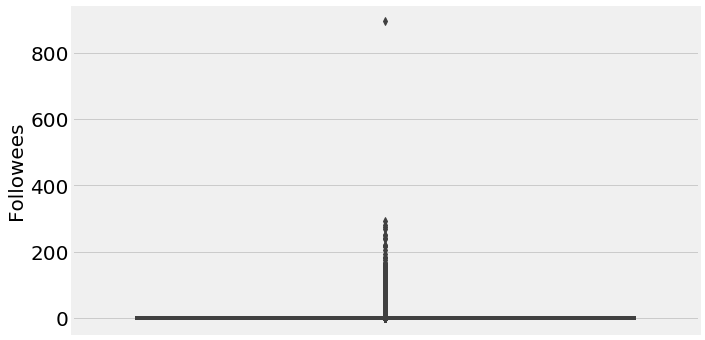

In [36]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(outdegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followees", fontsize = 20)
plt.show()

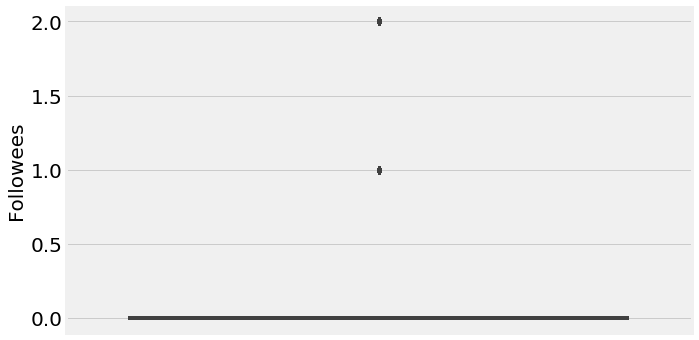

In [37]:
outdegreeValues = outdegreeValues[:250000]
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(outdegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followees", fontsize = 20)
plt.show()

In [44]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.90, 1.01, 0.01))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

90.0th percentile value = 2.0
91.0th percentile value = 3.0
92.0th percentile value = 3.0
93.0th percentile value = 4.0
94.0th percentile value = 5.0
95.0th percentile value = 6.0
96.0th percentile value = 8.0
97.0th percentile value = 10.0
98.0th percentile value = 13.0
99.0th percentile value = 19.0
100.0th percentile value = 895.0


In [45]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.99, 1.001, 0.001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

99.0th percentile value = 19.0
99.1th percentile value = 21.0
99.2th percentile value = 22.0
99.3th percentile value = 23.0
99.4th percentile value = 25.0
99.5th percentile value = 27.0
99.6th percentile value = 30.0
99.7th percentile value = 34.0
99.8th percentile value = 41.0
99.9th percentile value = 58.0
100.0th percentile value = 895.0


In [46]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.999, 1.0001, 0.0001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 2), quantile_values[list(quantile_values.keys())[i]]))

99.9th percentile value = 58.0
99.91th percentile value = 61.0
99.92th percentile value = 64.0
99.93th percentile value = 67.0
99.94th percentile value = 71.20939999999246
99.95th percentile value = 79.17449999996461
99.96th percentile value = 89.13959999999497
99.97th percentile value = 100.0
99.98th percentile value = 121.13959999999497
99.99th percentile value = 150.06979999993928
100.0th percentile value = 894.999999964959


Text(0.5,0,'Followees')

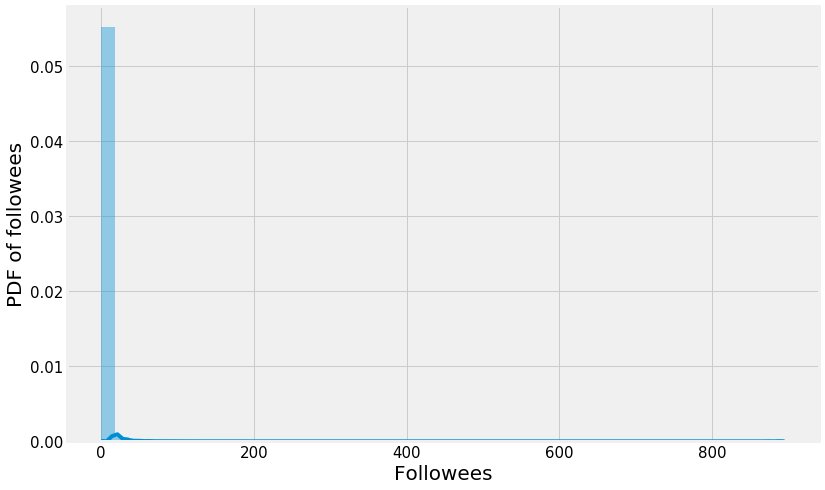

In [47]:
fig = plt.figure(figsize = (12,8))
sns.distplot(outdegree_series)
plt.ylabel("PDF of followees")
plt.xlabel("Followees")

__Observation:__<br>
Above plots shows that almost 99% of people have less than 19 followees and very few people have high number of followees. Here, the data is more steeper than followers data. Here, extremely few people follow high number of peoples.

### 1.6 Facts about followers and followee

In [49]:
print("Total number of people who are not followed by anyone = {} ({}%)".format(len(indegree_series) - np.count_nonzero(indegree_series), (len(indegree_series) - np.count_nonzero(indegree_series))/len(indegree_series)*100))

Total number of people who are not followed by anyone = 43099 (15.411654484859755%)


In [50]:
print("Total number of people who are not following anyone = {} ({}%)".format(len(outdegree_series) - np.count_nonzero(outdegree_series), (len(outdegree_series) - np.count_nonzero(outdegree_series))/len(outdegree_series)*100))

Total number of people who are not following anyone = 229640 (82.1163445997168%)


## 2. Posing Problem as a Classification Problem.

### 2.1 Generating equal number of edges which are not present in graph for supervised learning

In [61]:
def creatingMissingLinks():
    start = datetime.now()
    alreadPresentCheck = dict()
    eachVal = csv.reader(open("../Data/Train_New.csv", 'r'))
    for i in eachVal:
        alreadPresentCheck[(i[0], i[1])] = 1
        
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    missing_edges = set()
    
    while (len(missing_edges) < num_edges):
        sourceEdge = random.randint(1, num_nodes)
        destEdge = random.randint(1, num_nodes)
        toCheck = alreadPresentCheck.get((sourceEdge, destEdge), -1)
        
        if toCheck == -1 and sourceEdge != destEdge:
            try:
                if nx.shortest_path_length(G, source = sourceEdge, target = destEdge) > 2:
                    missing_edges.add((sourceEdge, destEdge))
                else:
                    continue
            except:
                missing_edges.add((sourceEdge, destEdge))
        else:
            continue
        #here, above except block will run if there is no path exists between "sourceEdge" and "destEdge" as in this case try
        #block will give error and hence except block will execute and it will add the path in missing_edges. It could be the
        #case, let say 3 people just joined facebook and they are just friends of each other, in this case non of them is 
        #connected to the global graph of facebook hence we cannot reach to these 3 people on facebook from any node of the 
        #global graph.
    
    print("Total Time taken = {}sec".format(datetime.now() - start))
    return missing_edges

missing_edges = creatingMissingLinks()
print(len(missing_edges))

Total Time taken = 0:00:04.113084sec
300000


In [62]:
data_raw['labels'] = np.ones(len(data_raw))
data_missingLinks = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
data_missingLinks['labels'] = np.zeros(len(data_missingLinks))
print(data_raw.shape)
print(data_missingLinks.shape)

(300000, 3)
(300000, 3)


In [63]:
data_raw.head()

,source_node,destination_node,labels
0,1,690569,1.0
1,1,315892,1.0
2,1,189226,1.0
3,2,834328,1.0
4,2,1615927,1.0


In [64]:
data_missingLinks.head()

,source_node,destination_node,labels
0,162608,142929,0.0
1,255342,118091,0.0
2,51492,255975,0.0
3,135003,103540,0.0
4,177339,159515,0.0


In [65]:
fullFrame = [data_raw, data_missingLinks]
completeData = pd.concat(fullFrame)
completeData = completeData.sort_values('source_node')
completeData.reset_index(drop = True, inplace = True)
completeData.to_csv("../Data/CompleteData.csv", index = False)
print(completeData.shape)

(600000, 3)


In [66]:
completeData.head()

,source_node,destination_node,labels
0,1,690569,1.0
1,1,315892,1.0
2,1,189226,1.0
3,1,183594,0.0
4,2,72915,0.0


In [67]:
completeData['labels'].value_counts()

1.0    300000
0.0    300000
Name: labels, dtype: int64

In [68]:
completeDataForGraph = completeData.drop('labels', axis = 1)
completeDataForGraph.to_csv("../Data/CompleteDataForGraph.csv", header = False, index = False)

## 3. Featurization

In [2]:
if os.path.isfile("../Data/CompleteDataForGraph.csv"):
    completeDataGraph =  nx.read_edgelist("../Data/CompleteDataForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)

print(nx.info(completeDataGraph))

Name: 
Type: DiGraph
Number of nodes: 457175
Number of edges: 600000
Average in degree:   1.3124
Average out degree:   1.3124


### 3.1 Jaccard Distance

http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [71]:
def jaccard_followees(s,d):
    try:
        if (len(set(completeDataGraph.successors(s))) == 0) or (len(set(completeDataGraph.successors(d))) == 0):
            return 0
        else:
            jf = (len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))) / (len(set(completeDataGraph.successors(s)).union(set(completeDataGraph.successors(d)))))
            return jf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    #A successor of n is a node m such that there exists a directed edge from n to m.
    

def jaccard_followers(s,d):
    try:
        if (len(set(completeDataGraph.predecessors(s))) == 0) or (len(set(completeDataGraph.predecessors(d))) == 0):
            return 0
        else:
            jf = (len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))) / (len(set(completeDataGraph.predecessors(s)).union(set(completeDataGraph.predecessors(d)))))
            return jf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    #A predecessor of n is a node m such that there exists a directed edge from m to n.

In [72]:
completeData['JaccardFollowers'] = completeData.apply(lambda row: jaccard_followers(row['source_node'], row['destination_node']), axis = 1)
completeData['JaccardFollowees'] = completeData.apply(lambda row: jaccard_followees(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees
0,1,690569,1.0,0.0,0.0
1,1,315892,1.0,0.0,0.0
2,1,189226,1.0,0.0,0.0
3,1,183594,0.0,0.0,0.0
4,2,72915,0.0,0.0,0.0


In [81]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Jaccard Followers =",max(completeData['JaccardFollowers']))
print("Min of Jaccard Followers =",min(completeData['JaccardFollowers']))
print("Max of Jaccard Followees =",max(completeData['JaccardFollowees']))
print("Min of Jaccard Followees =",min(completeData['JaccardFollowees']))

Max of Jaccard Followers = 0.8666666666666667
Min of Jaccard Followers = 0.0
Max of Jaccard Followees = 0.9649122807017544
Min of Jaccard Followees = 0.0


### 3.2 Cosine Distance (Otsuka-Ochiai coefficient)
\begin{equation}
CosineDistance = \frac{|X\cap Y|}{SQRT(|X|\cdot|Y|)} 
\end{equation}

In [82]:
def cosine_distance_followees(s,d):
    try:
        if (len(set(completeDataGraph.successors(s))) == 0) or (len(set(completeDataGraph.successors(d))) == 0):
            return 0
        else:
            cdf = (len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))) / (math.sqrt(len(set(completeDataGraph.successors(s))) * len(set(completeDataGraph.successors(d)))))
            return cdf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    
    
def cosine_distance_followers(s,d):
    try:
        if (len(set(completeDataGraph.predecessors(s))) == 0) or (len(set(completeDataGraph.predecessors(d))) == 0):
            return 0
        else:
            cdf = (len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))) / (math.sqrt(len(set(completeDataGraph.predecessors(s))) * len(set(completeDataGraph.predecessors(d)))))
            return cdf
    except:
        return 0
    #if a node does not exists in graph then except block will run

In [83]:
completeData['CosineDistanceFollowers'] = completeData.apply(lambda row: cosine_distance_followers(row['source_node'], row['destination_node']), axis = 1)
completeData['CosineDistanceFollowees'] = completeData.apply(lambda row: cosine_distance_followees(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees
0,1,690569,1.0,0.0,0.0,0.0,0.0
1,1,315892,1.0,0.0,0.0,0.0,0.0
2,1,189226,1.0,0.0,0.0,0.0,0.0
3,1,183594,0.0,0.0,0.0,0.0,0.0
4,2,72915,0.0,0.0,0.0,0.0,0.0


In [84]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Cosine Distance Followers =",max(completeData['CosineDistanceFollowers']))
print("Min of Cosine Distance Followers =",min(completeData['CosineDistanceFollowers']))
print("Max of Cosine Distance Followees =",max(completeData['CosineDistanceFollowees']))
print("Min of Cosine Distance Followees =",min(completeData['CosineDistanceFollowees']))

Max of Cosine Distance Followers = 0.9285714285714286
Min of Cosine Distance Followers = 0.0
Max of Cosine Distance Followees = 0.9821428571428571
Min of Cosine Distance Followees = 0.0


In [85]:
#experimented code

# a = [(1,100), (2, 150), (3, 250), (4, 350), (1, 200), (1, 300), (1, 450), (100, 200), (100, 300)]
# df = pd.DataFrame(a)
# df.to_csv("../Data/Temp.csv", header = False, index = False)
# tempGraph =  nx.read_edgelist("../Data/Temp.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)

# def jaccard_followees_temp(s,d):
#     try:
#         if (len(set(tempGraph.successors(s))) == 0) or (len(set(tempGraph.successors(d))) == 0):
#             return 0
#         else:
#             jf = (len(set(tempGraph.successors(s)).intersection(set(tempGraph.successors(d))))) / (len(set(tempGraph.successors(s)).union(set(tempGraph.successors(d)))))
#             return jf
#     except:
#         return 0
    
# def cosine_distance_followees_temp(s,d):
#     try:
#         if (len(set(tempGraph.successors(s))) == 0) or (len(set(tempGraph.successors(d))) == 0):
#             return 0
#         else:
#             cdf = (len(set(tempGraph.successors(s)).intersection(set(tempGraph.successors(d))))) / (math.sqrt(len(set(tempGraph.successors(s))) * len(set(tempGraph.successors(d)))))
#             return cdf
#     except:
#         return 0

### 3.3 Page Rank

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='../Data/PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

In [88]:
def pageRank():
    pr = nx.pagerank(completeDataGraph)
#   pr_sorted = dict(sorted(pr.items(), key = lambda x: x[1], reverse = True))
    return pr

In [89]:
pr_values = pageRank()
completeData['PageRankSource'] = completeData['source_node'].apply(lambda val: pr_values[val])
completeData['PageRankDest'] = completeData['destination_node'].apply(lambda val: pr_values[val])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006


In [91]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Page Rank Source =",max(completeData['PageRankSource']))
print("Min of Page Rank Source =",min(completeData['PageRankSource']))
print("Max of Page Rank Destination =",max(completeData['PageRankDest']))
print("Min of Page Rank Destination =",min(completeData['PageRankDest']))

Max of Page Rank Source = 1.1595610235273967e-05
Min of Page Rank Source = 1.3697667398947363e-06
Max of Page Rank Destination = 1.2835106416532055e-05
Min of Page Rank Destination = 1.371844107796286e-06


### 3.4 Shortest Path
Getting Shortest path between two nodes, if nodes have an edge i.e, trivially connected then we are removing that edge and calculating the shortest path.

In [5]:
def computeShortestPath(s, d):
    sd = -1
    try:
        if completeDataGraph.has_edge(s, d):
            completeDataGraph.remove_edge(s, d)
            try:
                sd = nx.shortest_path_length(completeDataGraph, source = s, target = d)
                train_graph.add_edge(s, d)
            except:
                train_graph.add_edge(s, d)
        else:
            sd = nx.shortest_path_length(completeDataGraph, source = s, target = d)
        return sd
    except:
        return sd

In [94]:
completeData['ShortestPathLength'] = completeData.apply(lambda row: computeShortestPath(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1


In [95]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Shortest Path =",max(completeData['ShortestPathLength']))
print("Min of Shortest Path =",min(completeData['ShortestPathLength']))

Max of Shortest Path = 278
Min of Shortest Path = -1


In [96]:
# Experimented Code
# a = [(1,100), (2, 150), (3, 250), (4, 350), (1, 200), (1, 300), (1, 450), (100, 200), (100, 300)]
# df = pd.DataFrame(a)
# df.to_csv("../Data/Temp.csv", header = False, index = False)
# tempGraph =  nx.read_edgelist("../Data/Temp.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
# print(nx.info(tempGraph))

# def computeShortestPath(s, d):
#     sd = -1
#     try:
#         if tempGraph.has_edge(s, d):
#             tempGraph.remove_edge(s, d)
#             try:
#                 sd = nx.shortest_path_length(tempGraph, source = s, target = d)
#                 tempGraph.add_edge(s, d)
#             except:
#                 tempGraph.add_edge(s, d)
#         else:
#             sd = nx.shortest_path_length(tempGraph, source = s, target = d)
#         return sd
#     except:
#         return sd
    
# computeShortestPath(1, 450)

### 3.5 Checking same component--Community

In [6]:
wcc = list(nx.weakly_connected_components(completeDataGraph))
def check_same_wcc(s, d):
    same_wcc = 0
    if completeDataGraph.has_edge(s, d):
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            completeDataGraph.remove_edge(s, d)
            if computeShortestPath(s, d) == -1:
                completeDataGraph.add_edge(s, d)
                return 0
            else:
                completeDataGraph.add_edge(s, d)
                return 1
        else:
            return 0
        
    elif completeDataGraph.has_edge(d, s):
        for i in wcc:
            if d in i:
                same_wcc = i
                break
        if s in same_wcc:
            completeDataGraph.remove_edge(d, s)
            if computeShortestPath(d, s) == -1:
                completeDataGraph.add_edge(d, s)
                return 0
            else:
                completeDataGraph.add_edge(d, s)
                return 1
        else:
            return 0
        
    else:
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            return 1
        else:
            return 0
        
#In above code:
#first, we are checking that is there is a direct edge from s to d. If yes, then we are checking do both s and d belong to same 
#wcc. If yes, then we have removed the direct edge from s to d and calculated the shortest path from s to d. If the 
#shortest path does not exist then we are declaring that they are not in same wcc even though both of them belong to same wcc. 
#However, if there exists a shortest path from s to d then it means they could be friends and hence we are declaring them in 
#wcc.
#second, we are checking that is there is a direct edge from d to s. If yes, then we are checking do both d and s belong to same 
#wcc. If yes, then we have removed the direct edge from d to s and calculated the shortest path from d to s. If the 
#shortest path does not exist then we are declaring that they are not in same wcc even though both of them belong to same wcc. 
#However, if there exists a shortest path from d to s then it means they could be friends and hence we are declaring them in 
#wcc.
#If, however, there is no direct edge from s to d or from d to s at the first place then we are simply checking that do they 
#belong to same wcc. If yes, then just return 1 else 0.

#why we have checked for the existence of direct path from s to d and from d to s because in our dataset all of the data points
#have paths from s to d or from d to s so if we don't check for this condition then it will return 1 everywhere in all the
#data-points. Hence, if there is a direct path then we have used this strategy that we will remove this direct path and check 
#does s is reachable from d or d is reachable from s via indirect path, if yes then only we are declaring them in same wcc else 
#not.

In [7]:
completeData['SameComponent'] = completeData.apply(lambda row: check_same_wcc(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,SameComponent
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,0
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,0


In [21]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Number of zeros in Same Component =",len(completeData['SameComponent']) - np.count_nonzero(completeData['SameComponent']))
print("Number of ones in Same Component =",np.count_nonzero(completeData['SameComponent']))

Number of zeros in Same Component = 502729
Number of ones in Same Component = 97271


### 3.6 Adar Index

In [11]:
def calc_adar_index(s, d):
    adar_sum = 0
    try:
        common_followers = list(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))
        if len(common_followers)!=0:
            for i in common_followers:
                adar_sum += 1/np.log10(len(set(completeDataGraph.predecessors(i))))
            return adar_sum
        else:
            return 0
    except:
        return 0

In [12]:
completeData['AdarIndex'] = completeData.apply(lambda row: calc_adar_index(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,SameComponent,AdarIndex
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,0,0.0
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,0,0.0


In [13]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Adar Index =",max(completeData['AdarIndex']))
print("Min of Adar Index =",min(completeData['AdarIndex']))

Max of Adar Index = 495.0374132836214
Min of Adar Index = 0.0


### 3.7 Follow Back

In [15]:
def does_followBack(s, d):
    try:
        if completeDataGraph.has_edge(d, s):
            return 1
        else:
            return 0
    except:
        return 0

In [16]:
completeData['FollowBack'] = completeData.apply(lambda row: does_followBack(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,SameComponent,AdarIndex,FollowBack
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,0,0.0,0
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,0,0.0,0


In [20]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Number of zeros in Follow Back =",len(completeData['FollowBack']) - np.count_nonzero(completeData['FollowBack']))
print("Number of ones in Follow Back=",np.count_nonzero(completeData['FollowBack']))

Number of zeros in Follow Back = 593572
Number of ones in Follow Back= 6428


### 3.8 Katz Centrality
https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [23]:
def calc_katz():
    katz = nx.katz_centrality(completeDataGraph, alpha = 0.005, max_iter = 500)
    return katz

In [24]:
katz_values = calc_katz()
completeData['KatzCentralitySource'] = completeData['source_node'].apply(lambda val: katz_values[val])
completeData['KatzCentralityDest'] = completeData['destination_node'].apply(lambda val: katz_values[val])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,SameComponent,AdarIndex,FollowBack,KatzCentralitySource,KatzCentralityDest
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001477
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001484
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001477
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,0,0.0,0,0.001469,0.001499
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,0,0.0,0,0.001484,0.001506


In [25]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)
print("Max of Katz Centrality source=",max(completeData['KatzCentralitySource']))
print("Min of Katz Centrality source=",min(completeData['KatzCentralitySource']))
print("Max of Katz Centrality destination =",max(completeData['KatzCentralityDest']))
print("Min of Katz Centrality destination =",min(completeData['KatzCentralityDest']))

Max of Katz Centrality source= 0.0015743249911135434
Min of Katz Centrality source= 0.0014692384458904518
Max of Katz Centrality destination = 0.0016104864387082164
Min of Katz Centrality destination = 0.001476584638119904


### 3.9 HITS Score

In [27]:
def calc_HITS():
    hitz = nx.hits(completeDataGraph, max_iter=200, tol=1e-08, nstart=None, normalized=True)
    return hitz

In [28]:
hits_values = calc_HITS()
completeData['HitsHubsSource'] = completeData['source_node'].apply(lambda val: hits_values[0][val])
completeData['HitsHubsDest'] = completeData['destination_node'].apply(lambda val: hits_values[0][val])
completeData['HitsAuthSource'] = completeData['source_node'].apply(lambda val: hits_values[1][val])
completeData['HitsAuthDest'] = completeData['destination_node'].apply(lambda val: hits_values[1][val])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,SameComponent,AdarIndex,FollowBack,KatzCentralitySource,KatzCentralityDest,HitsHubsSource,HitsHubsDest,HitsAuthSource,HitsAuthDest
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001477,1.894121e-19,0.000000e+00,0.000000e+00,1.214823e-21
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001484,1.894121e-19,0.000000e+00,0.000000e+00,1.196168e-18
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0.0,0,0.001469,0.001477,1.894121e-19,0.000000e+00,0.000000e+00,1.214823e-21
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,0,0.0,0,0.001469,0.001499,1.894121e-19,4.970945e-19,0.000000e+00,1.243709e-21
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,0,0.0,0,0.001484,0.001506,1.315095e-14,1.000352e-22,3.138817e-23,8.268520e-14


In [29]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)

print("Max of Hits Hub Source =",max(completeData['HitsHubsSource']))
print("Min of Hits Hubs Source=",min(completeData['HitsHubsSource']))

print("Max of Hits Hubs Dest=",max(completeData['HitsHubsDest']))
print("Min of Hits Hubs Dest=",min(completeData['HitsHubsDest']))

print("Max of Hits Auth Source=",max(completeData['HitsAuthSource']))
print("Min of Hits Auth Source=",min(completeData['HitsAuthSource']))

print("Max of Hits Auth Dest=",max(completeData['HitsAuthDest']))
print("Min of Hits Auth Dest=",min(completeData['HitsAuthDest']))

Max of Hits Hub Source = 0.10178928807874423
Min of Hits Hubs Source= 0.0
Max of Hits Hubs Dest= 0.10178928807874423
Min of Hits Hubs Dest= 0.0
Max of Hits Auth Source= 0.00514831378080992
Min of Hits Auth Source= 0.0
Max of Hits Auth Dest= 0.0061686386675020135
Min of Hits Auth Dest= 0.0


### 3.10 Adding Following features
1.  Number of followers of source
2.  Number of followees of source
3.  Number of followers of destination
4.  Number of followees of destination
5.  Common Followers of source and destination
6.  Common followeers of source of destination

In [32]:
def followers_followees(s, d):
    numFollowersSource = len(set(completeDataGraph.predecessors(s)))
    numFolloweesSource = len(set(completeDataGraph.successors(s)))
    numFollowersDest = len(set(completeDataGraph.predecessors(d)))
    numFolloweesDest = len(set(completeDataGraph.successors(d)))
    numCommonFollowers = len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))
    numCommonFollowees = len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))
    
    return numFollowersSource, numFolloweesSource, numFollowersDest, numFolloweesDest, numCommonFollowers, numCommonFollowees

In [33]:
followers_followees_feats = list(completeData.apply(lambda row: list(followers_followees(row['source_node'], row['destination_node'])), axis = 1))
df_temp = pd.DataFrame(followers_followees_feats, columns = ['NumFollowersSource', 'NumFolloweesSource', 'NumFollowersDest', 'NumFolloweesDest', 'NumCommonFollowers', 'NumCommonFollowees'])
completeData = pd.concat([completeData, df_temp], axis=1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,...,HitsHubsSource,HitsHubsDest,HitsAuthSource,HitsAuthDest,NumFollowersSource,NumFolloweesSource,NumFollowersDest,NumFolloweesDest,NumCommonFollowers,NumCommonFollowees
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,1.894121e-19,0.000000e+00,0.000000e+00,1.214823e-21,0,4,1,0,0,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,1.894121e-19,0.000000e+00,0.000000e+00,1.196168e-18,0,4,2,0,0,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,1.894121e-19,0.000000e+00,0.000000e+00,1.214823e-21,0,4,1,2,0,0
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,...,1.894121e-19,4.970945e-19,0.000000e+00,1.243709e-21,0,4,4,4,0,0
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,...,1.315095e-14,1.000352e-22,3.138817e-23,8.268520e-14,2,8,5,1,0,0


In [34]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)

print("Max of Num Followers Source=",max(completeData['NumFollowersSource']))
print("Min of Num Followers Source=",min(completeData['NumFollowersSource']))

print("Max of Num Followees Source=",max(completeData['NumFolloweesSource']))
print("Min of Num Followees Source=",min(completeData['NumFolloweesSource']))

print("Max of Num Followers Dest=",max(completeData['NumFollowersDest']))
print("Min of Num Followers Dest=",min(completeData['NumFollowersDest']))

print("Max of Num Followees Dest=",max(completeData['NumFolloweesDest']))
print("Min of Num Followees Dest=",min(completeData['NumFolloweesDest']))

print("Max of Num Common Followers=",max(completeData['NumCommonFollowers']))
print("Min of Num Common Followers=",min(completeData['NumCommonFollowers']))

print("Max of Num Common Followees=",max(completeData['NumCommonFollowees']))
print("Min of Num Common Followees=",min(completeData['NumCommonFollowees']))

Max of Num Followers Source= 14
Min of Num Followers Source= 0
Max of Num Followees Source= 895
Min of Num Followees Source= 1
Max of Num Followers Dest= 19
Min of Num Followers Dest= 1
Max of Num Followees Dest= 295
Min of Num Followees Dest= 0
Max of Num Common Followers= 13
Min of Num Common Followers= 0
Max of Num Common Followees= 210
Min of Num Common Followees= 0


### 3.11 Adding Weight Features

1. Weight of incoming edge of destination node
2. Weight of outgoing edge of source node
3. Weight of incoming edges + weight of outgoing edges
4. Weight of incoming edges $*$ weight of outgoing edges
5. 2*weight of incoming edges + weight of outgoing edges
6. Weight of incoming edges + 2*weight of outgoing edges

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

In [37]:
def weight_features():
    weight_in = {}
    weight_out = {}
    for i in completeDataGraph.nodes():
        weight_in[i] = 1/(np.sqrt(1+len(set(completeDataGraph.predecessors(i)))))
        weight_out[i] = 1/(np.sqrt(1+len(set(completeDataGraph.successors(i)))))
    return weight_in, weight_out

In [38]:
weight_in, weight_out = weight_features()
completeData['WeightIncoming'] = completeData['destination_node'].apply(lambda val: weight_in[val])
completeData['WeightOutgoing'] = completeData['source_node'].apply(lambda val: weight_out[val])
completeData['Weight_I+O'] = completeData['WeightIncoming'] + completeData['WeightOutgoing']
completeData['Weight_I*O'] = completeData['WeightIncoming'] * completeData['WeightOutgoing']
completeData['Weight_2*I+O'] = (2*completeData['WeightIncoming'] + completeData['WeightOutgoing'])
completeData['Weight_I+2*O'] = (completeData['WeightIncoming'] + 2*completeData['WeightOutgoing'])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,...,NumFollowersDest,NumFolloweesDest,NumCommonFollowers,NumCommonFollowees,WeightIncoming,WeightOutgoing,Weight_I+O,Weight_I*O,Weight_2*I+O,Weight_I+2*O
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,1,0,0,0,0.707107,0.447214,1.154320,0.316228,1.861427,1.601534
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,2,0,0,0,0.577350,0.447214,1.024564,0.258199,1.601914,1.471777
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,1,2,0,0,0.707107,0.447214,1.154320,0.316228,1.861427,1.601534
3,1,183594,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,-1,...,4,4,0,0,0.447214,0.447214,0.894427,0.200000,1.341641,1.341641
4,2,72915,0.0,0.0,0.0,0.0,0.0,0.000003,0.000006,-1,...,5,1,0,0,0.408248,0.333333,0.741582,0.136083,1.149830,1.074915


In [39]:
completeData.to_csv("../Data/CompleteDataWithFeat.csv", index = False)

print("Max of Weight Incoming=",max(completeData['WeightIncoming']))
print("Min of Weight Incoming=",min(completeData['WeightIncoming']))

print("Max of Weight Outgoing=",max(completeData['WeightOutgoing']))
print("Min of Weight Outgoing=",min(completeData['WeightOutgoing']))

print("Max of Weight_I+O=",max(completeData['Weight_I+O']))
print("Min of Weight_I+O=",min(completeData['Weight_I+O']))

print("Max of Weight_I*O=",max(completeData['Weight_I*O']))
print("Min of Weight_I*O=",min(completeData['Weight_I*O']))

print("Max of Weight_2*I+O=",max(completeData['Weight_2*I+O']))
print("Min of Weight_2*I+O=",min(completeData['Weight_2*I+O']))

print("Max of Weight_I+2*O=",max(completeData['Weight_I+2*O']))
print("Min of Weight_I+2*O=",min(completeData['Weight_I+2*O']))

Max of Weight Incoming= 0.7071067811865475
Min of Weight Incoming= 0.22360679774997896
Max of Weight Outgoing= 0.7071067811865475
Min of Weight Outgoing= 0.03340765523905305
Max of Weight_I+O= 1.414213562373095
Min of Weight_I+O= 0.28340765523905304
Max of Weight_I*O= 0.4999999999999999
Min of Weight_I*O= 0.008351913809763262
Max of Weight_2*I+O= 2.1213203435596424
Min of Weight_2*I+O= 0.5275355283902078
Max of Weight_I+2*O= 2.1213203435596424
Min of Weight_I+2*O= 0.31681531047810607


In [40]:
completeData.shape

(600000, 31)

## 4. Train, CV and Test Split (75%, 10% and 15% resp)

In [30]:
completeData = pd.read_csv("../Data/CompleteDataWithFeat.csv")
X_Train, Test, Y_Train, TestLabels = train_test_split(completeData, completeData['labels'], stratify=completeData['labels'], test_size=0.15)
Train, CV, TrainLabels, CVLabels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.117647)

Train = Train.sort_values('source_node')
Train.reset_index(drop = True, inplace = True)
TrainLabels = Train['labels']
TrainForGraph = Train[['source_node', 'destination_node']]
Train = Train.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(Train, open("../Data/TrainData.sav", "wb"))
pickle.dump(TrainLabels, open("../Data/TrainLabels.sav", "wb"))
TrainForGraph.to_csv("../Data/TrainForGraph.csv", header = False, index = False)

CV = CV.sort_values('source_node')
CV.reset_index(drop = True, inplace = True)
CVLabels = CV['labels']
CVForGraph = CV[['source_node', 'destination_node']]
CV = CV.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(CV, open("../Data/CV.sav", "wb"))
pickle.dump(CVLabels, open("../Data/CVLabels.sav", "wb"))
CVForGraph.to_csv("../Data/CVForGraph.csv", header = False, index = False)

Test = Test.sort_values('source_node')
Test.reset_index(drop = True, inplace = True)
TestLabels = Test['labels']
TestForGraph = Test[['source_node', 'destination_node']]
Test = Test.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(Test, open("../Data/Test.sav", "wb"))
pickle.dump(TestLabels, open("../Data/TestLabels.sav", "wb"))
TestForGraph.to_csv("../Data/TestForGraph.csv", header = False, index = False)


print('Number of data points in train data:', Train.shape)
print('Train data labels shape:', TrainLabels.shape,'\n')

print('Number of data points in test data:', Test.shape)
print('Test data labels shape:', TestLabels.shape,'\n')

print('Number of data points in cross validation data:', CV.shape)
print('CV data labels shape:', CVLabels.shape,'\n')

Number of data points in train data: (450000, 28)
Train data labels shape: (450000,) 

Number of data points in test data: (90000, 28)
Test data labels shape: (90000,) 

Number of data points in cross validation data: (60000, 28)
CV data labels shape: (60000,) 



In [32]:
print("----------Distribution of output variable in train data----------")
print("Class 0: {}%               Class 1: {}%:\n".format((TrainLabels.value_counts()[0]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100, (TrainLabels.value_counts()[1]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in test data----------")
print("Class 0: {}%               Class 1: {}%:\n".format((TestLabels.value_counts()[0]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100, (TestLabels.value_counts()[1]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in CV data----------")
print("Class 0: {}%               Class 1: {}%:".format((CVLabels.value_counts()[0]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100, (CVLabels.value_counts()[1]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100))

----------Distribution of output variable in train data----------
Class 0: 50.0%               Class 1: 50.0%:

----------Distribution of output variable in test data----------
Class 0: 50.0%               Class 1: 50.0%:

----------Distribution of output variable in CV data----------
Class 0: 50.0%               Class 1: 50.0%:


In [33]:
if (os.path.isfile("../Data/TrainForGraph.csv")) and (os.path.isfile("../Data/CVForGraph.csv")) and (os.path.isfile("../Data/TestForGraph.csv")):
    
    trainGraph =  nx.read_edgelist("../Data/TrainForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    CVGraph = nx.read_edgelist("../Data/CVForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    TestGraph = nx.read_edgelist("../Data/TestForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    
    print("TRAIN")
    print(nx.info(trainGraph)+"\n")
    print("CV")
    print(nx.info(CVGraph)+"\n")
    print("TEST")
    print(nx.info(TestGraph)+"\n")
    
    trainNodes =  set(trainGraph.nodes())
    CVNodes = set(CVGraph.nodes())
    TestNodes = set(TestGraph.nodes())
    
    train_cv_common = trainNodes.intersection(CVNodes)
    train_test_common = trainNodes.intersection(TestNodes)
    
    train_cv_uncommon = len(CVNodes - trainNodes)
    train_test_uncommon = len(TestNodes - trainNodes)
    
    print("Number of people common in Train and CV = {} ({}%)".format(len(train_cv_common), (len(train_cv_common)/len(CVNodes))*100))
    print("Number of people common in Train and Test = {} ({}%)\n".format(len(train_test_common), (len(train_test_common)/len(TestNodes))*100))
    
    print("Number of people present in CV but not in train = {} ({}%)".format(train_cv_uncommon, (train_cv_uncommon/len(CVNodes))*100))
    print("Number of people present in test but not in train = {} ({}%)".format(train_test_uncommon, (train_test_uncommon/len(TestNodes))*100))

TRAIN
Name: 
Type: DiGraph
Number of nodes: 395304
Number of edges: 450000
Average in degree:   1.1384
Average out degree:   1.1384

CV
Name: 
Type: DiGraph
Number of nodes: 95743
Number of edges: 60000
Average in degree:   0.6267
Average out degree:   0.6267

TEST
Name: 
Type: DiGraph
Number of nodes: 133448
Number of edges: 90000
Average in degree:   0.6744
Average out degree:   0.6744

Number of people common in Train and CV = 69124 (72.19744524403873%)
Number of people common in Train and Test = 94534 (70.83957796295186%)

Number of people present in CV but not in train = 26619 (27.802554755961275%)
Number of people present in test but not in train = 38914 (29.16042203704814%)


__We have a cold start problem__

## 5. Machine Learning Models

In [36]:
Train = pickle.load(open("../Data/TrainData.sav", "rb"))
TrainLabels = np.array(pickle.load(open("../Data/TrainLabels.sav", "rb")))
CV = pickle.load(open("../Data/CV.sav", "rb"))
CVLabels = np.array(pickle.load(open("../Data/CVLabels.sav", "rb")))
Test = pickle.load(open("../Data/Test.sav", "rb"))
TestLabels = np.array(pickle.load(open("../Data/TestLabels.sav", "rb")))

print("Shape of Train Data = {}".format(Train.shape))
print("Shape of Train Labels = {}\n".format(TrainLabels.shape))
print("Shape of CV Data = {}".format(CV.shape))
print("Shape of CV Labels = {}\n".format(CVLabels.shape))
print("Shape of Test Data = {}".format(Test.shape))
print("Shape of Test Labels = {}\n".format(TestLabels.shape))

Shape of Train Data = (450000, 28)
Shape of Train Labels = (450000,)

Shape of CV Data = (60000, 28)
Shape of CV Labels = (60000,)

Shape of Test Data = (90000, 28)
Shape of Test Labels = (90000,)



In [37]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    plt.figure(figsize=(25, 7))
    labels = [0, 1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplots_adjust(wspace = 0.25)
    plt.show()

In [154]:
F1_Score = []
Accuracy_Scores = []

### 5.1 Logistic Regression

For alpha value of 1e-05 CV F1 Score = 0.8952166976002085
For alpha value of 0.0001 CV F1 Score = 0.9042109980579945
For alpha value of 0.001 CV F1 Score = 0.9006374699892375
For alpha value of 0.01 CV F1 Score = 0.8843283582089553
For alpha value of 0.1 CV F1 Score = 0.880012023847297
For alpha value of 1 CV F1 Score = 0.8695488593220919
For alpha value of 10 CV F1 Score = 0.7271742342164879
For alpha value of 100 CV F1 Score = 0.0
For alpha value of 1000 CV F1 Score = 0.6666666666666666
For alpha value of 10000 CV F1 Score = 0.6666666666666666


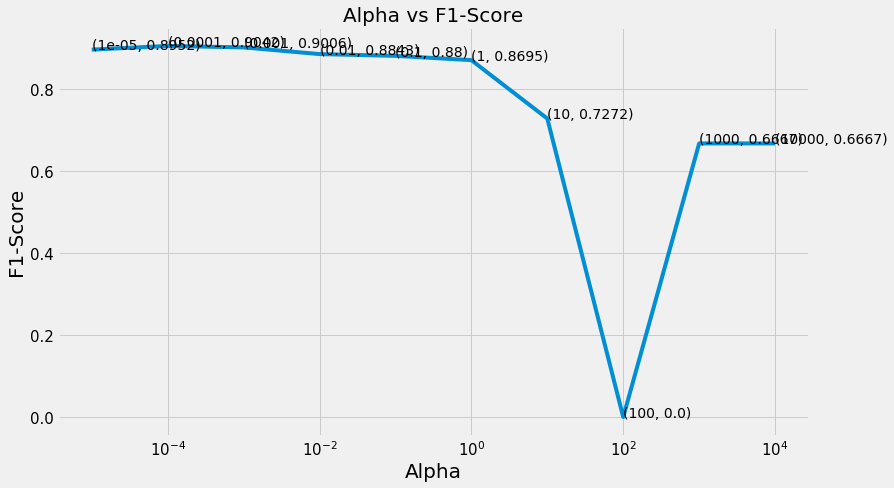

In [40]:
Scalar = StandardScaler()
Scalar.fit(Train)
TrainStd = Scalar.transform(Train)
CVStd = Scalar.transform(CV)
TestStd = Scalar.transform(Test)

alpha = [10**x for x in range(-5, 5)]

cv_f1_Score = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(TrainStd, TrainLabels)
    predicted_y = clf.predict(CVStd)
    cv_f1_Score.append(f1_score(CVLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV F1 Score = "+str(f1_score(CVLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_f1_Score)
for xy in zip(alpha, np.round(cv_f1_Score, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs F1-Score", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("F1-Score", fontsize = 20)
plt.show()

For values of best alpha = 0.0001, Test F1-Score = 0.9042331560283687, Test Accuracy Score = 90.4%


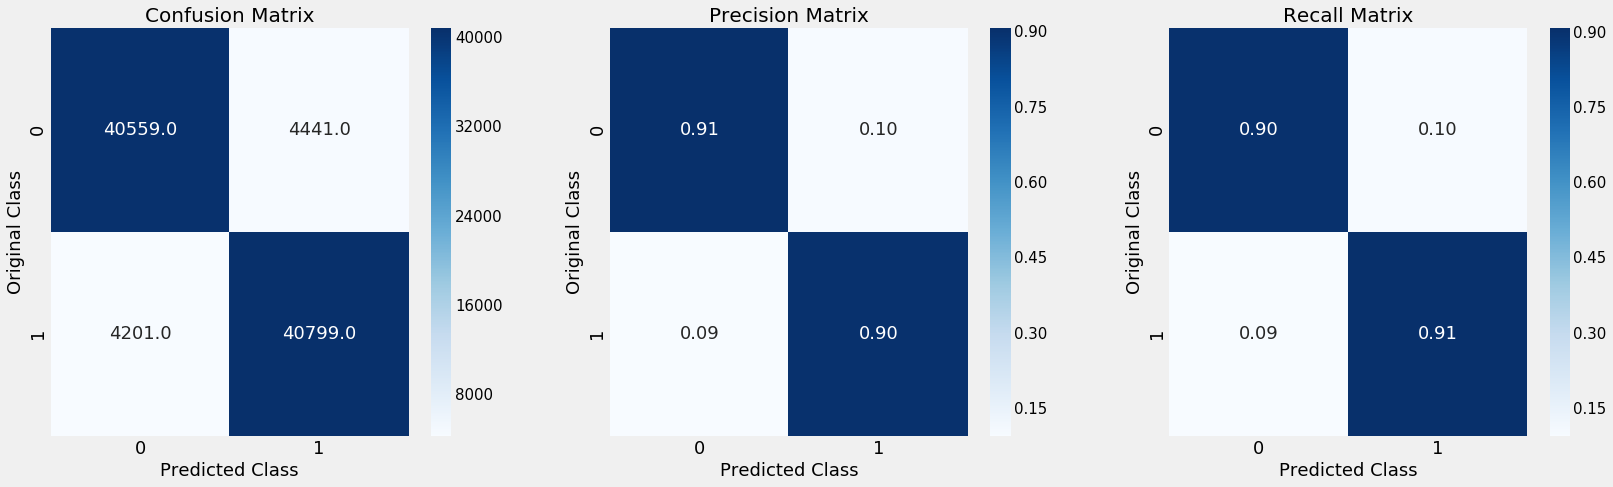

In [155]:
best_alpha = alpha[np.argmax(cv_f1_Score)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainStd, TrainLabels)

predict_test = clf.predict(TestStd)
LR_F1_Score = f1_score(TestLabels, predict_test)
LR_Accuracy = accuracy_score(TestLabels, predict_test)
print('For values of best alpha = {}, Test F1-Score = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_F1_Score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, predict_test)

F1_Score.append(LR_F1_Score)
Accuracy_Scores.append(LR_Accuracy)

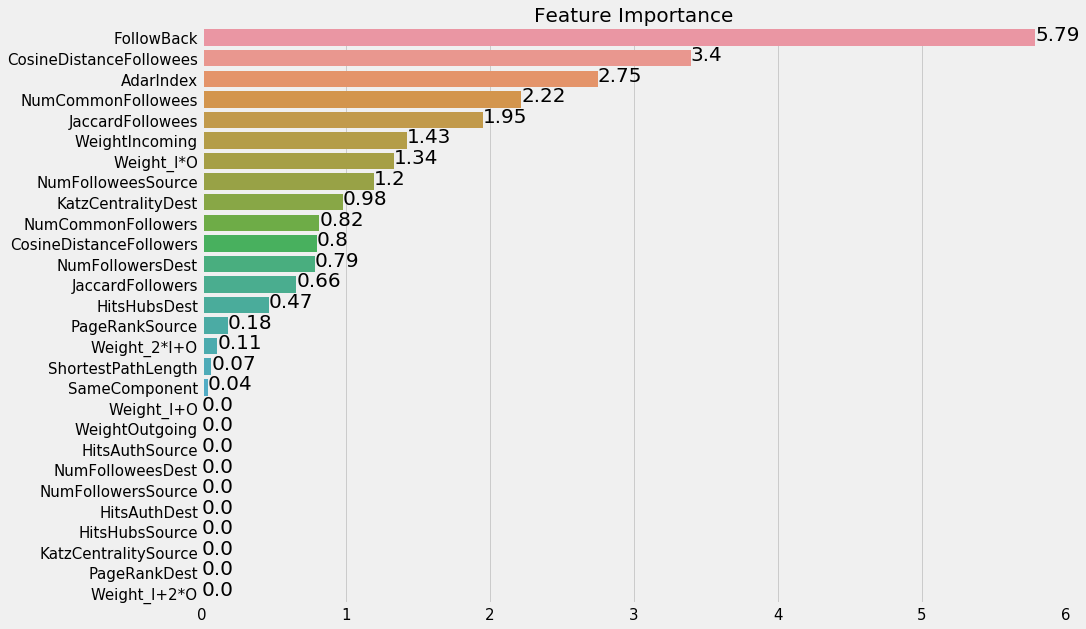

In [156]:
a = clf.coef_[0]
b = []
for i in a:
    if i>0:
        b.append(i)
    else:
        b.append(0)
imp_feat_df = pd.DataFrame({'Feature_Names':list(Train.columns), "Importance":list(b)})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
axes.set(xlim=(0, 6))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(round(i.get_width(), 2)), fontsize=20, color='black')
plt.show()

### 5.2 SVM

For alpha value of 1e-07 CV F1 Score = 0.7595084243182558
For alpha value of 1e-06 CV F1 Score = 0.8877850380050674
For alpha value of 1e-05 CV F1 Score = 0.9010210190773612
For alpha value of 0.0001 CV F1 Score = 0.90781425435289
For alpha value of 0.001 CV F1 Score = 0.9034429028461551
For alpha value of 0.01 CV F1 Score = 0.8891900132118297
For alpha value of 0.1 CV F1 Score = 0.8847105559950847
For alpha value of 1 CV F1 Score = 0.8697086878061356
For alpha value of 10 CV F1 Score = 0.3798687325156015
For alpha value of 100 CV F1 Score = 0.0
For alpha value of 1000 CV F1 Score = 0.0
For alpha value of 10000 CV F1 Score = 0.6666666666666666


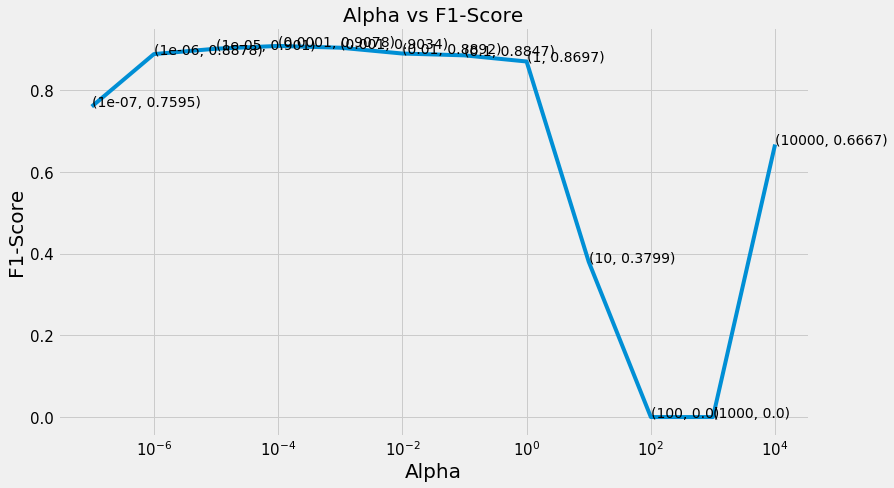

In [48]:
alpha = [10**x for x in range(-7, 5)]

cv_f1_Score = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i)
    clf.fit(TrainStd, TrainLabels)
    predicted_y = clf.predict(CVStd)
    cv_f1_Score.append(f1_score(CVLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV F1 Score = "+str(f1_score(CVLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_f1_Score)
for xy in zip(alpha, np.round(cv_f1_Score, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs F1-Score", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("F1-Score", fontsize = 20)
plt.show()

For values of best alpha = 0.0001, Test F1-Score = 0.9032158181094353, Test Accuracy Score = 90.28%


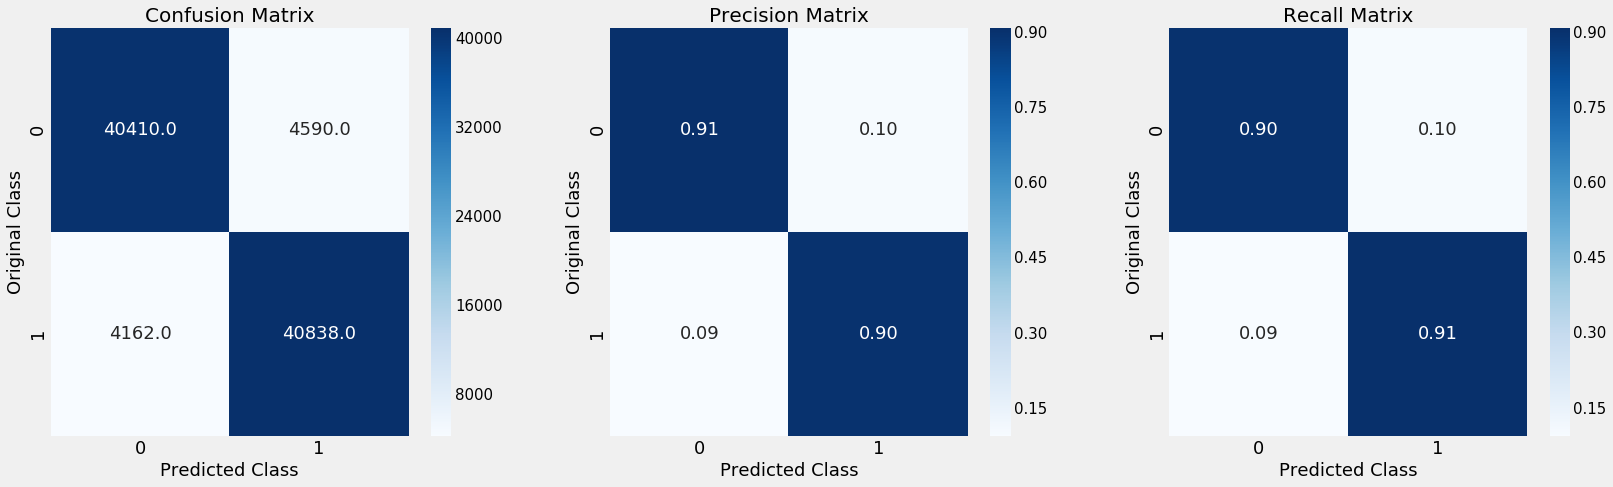

In [157]:
best_alpha = alpha[np.argmax(cv_f1_Score)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainStd, TrainLabels)

predict_test = clf.predict(TestStd)
LR_F1_Score = f1_score(TestLabels, predict_test)
LR_Accuracy = accuracy_score(TestLabels, predict_test)
print('For values of best alpha = {}, Test F1-Score = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_F1_Score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, predict_test)

F1_Score.append(LR_F1_Score)
Accuracy_Scores.append(LR_Accuracy)

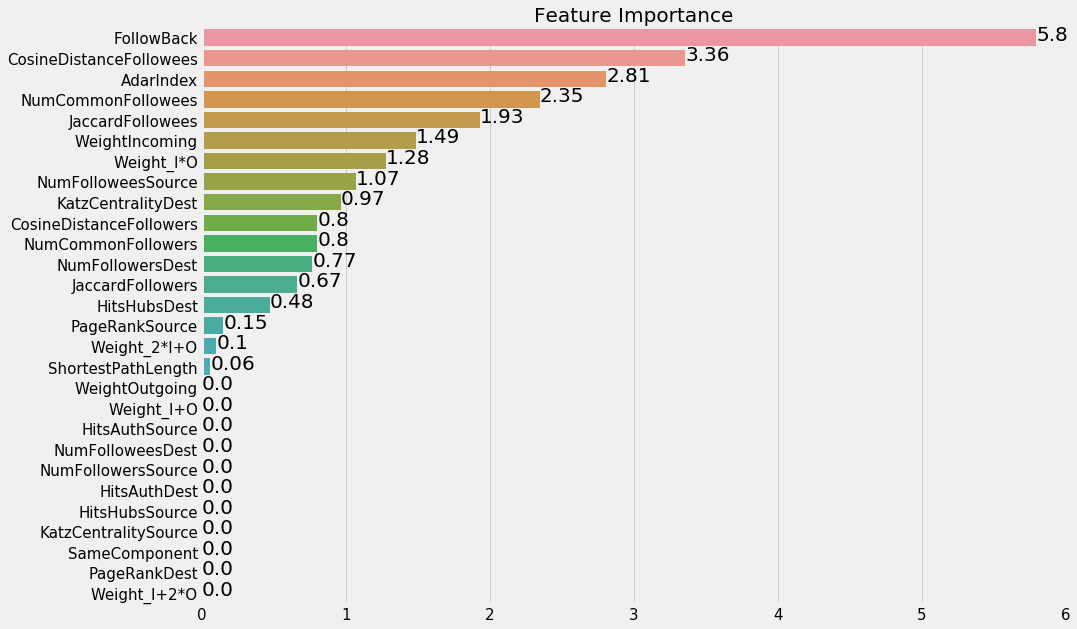

In [158]:
a = clf.coef_[0]
b = []
for i in a:
    if i>0:
        b.append(i)
    else:
        b.append(0)
imp_feat_df = pd.DataFrame({'Feature_Names':list(Train.columns), "Importance":list(b)})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
axes.set(xlim=(0, 6))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(round(i.get_width(), 2)), fontsize=20, color='black')
plt.show()

### 5.3 XGBoost

In [55]:
#https://xgboost.readthedocs.io/en/latest/python/python_intro.html

def f1_error(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(Train, label=TrainLabels)
d_test = xgb.DMatrix(CV, label=CVLabels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, feval = f1_error, verbose_eval=10)

[0]	train-error:0.089496	valid-error:0.087667	train-f1_err:0.090591	valid-f1_err:0.088475
Multiple eval metrics have been passed: 'valid-f1_err' will be used for early stopping.

Will train until valid-f1_err hasn't improved in 20 rounds.
[10]	train-error:0.088822	valid-error:0.087067	train-f1_err:0.089853	valid-f1_err:0.087813
[20]	train-error:0.088482	valid-error:0.08655	train-f1_err:0.089432	valid-f1_err:0.087211
[30]	train-error:0.088396	valid-error:0.086383	train-f1_err:0.089504	valid-f1_err:0.087202
[40]	train-error:0.089567	valid-error:0.088067	train-f1_err:0.088014	valid-f1_err:0.086337
[50]	train-error:0.089673	valid-error:0.088217	train-f1_err:0.087909	valid-f1_err:0.086311
Stopping. Best iteration:
[37]	train-error:0.08954	valid-error:0.087717	train-f1_err:0.088096	valid-f1_err:0.086114



Test F1-Score = 0.9120906609242281, Test Accuracy Score = 91.02%


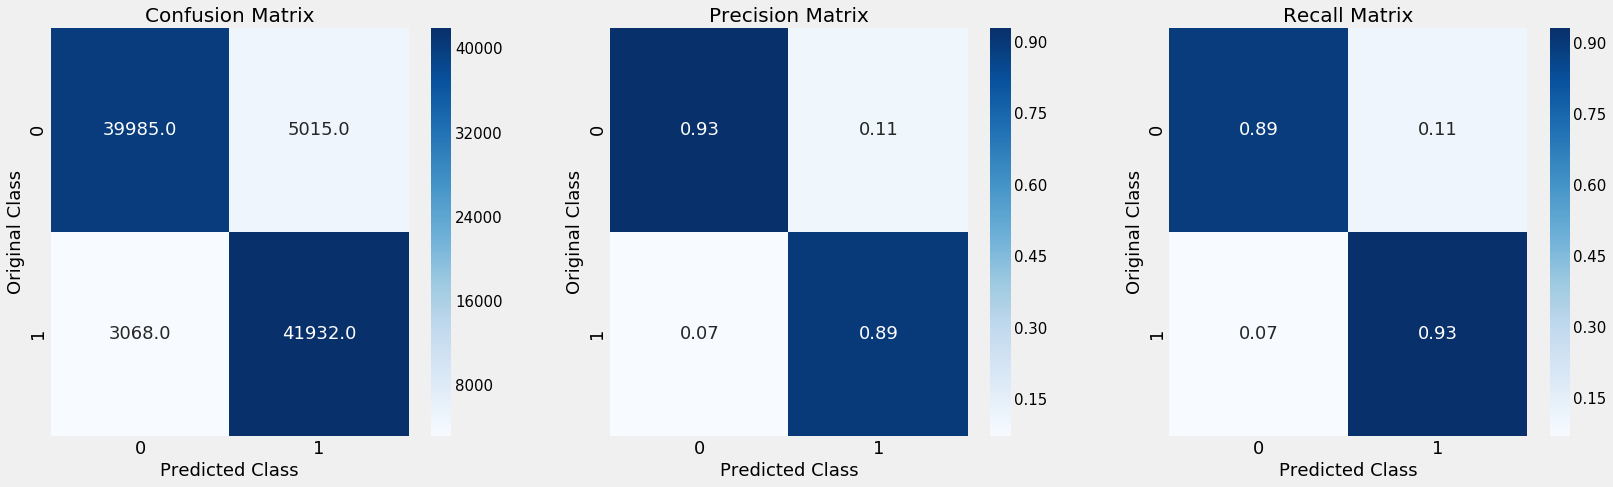

In [159]:
d_test = xgb.DMatrix(Test)
y_pred = list(map(lambda x: int(x>0.5), bst.predict(d_test)))
LR_F1_score = f1_score(TestLabels, y_pred)
LR_Accuracy = accuracy_score(TestLabels, y_pred)
print('Test F1-Score = {}, Test Accuracy Score = {}%'.format(LR_F1_score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, y_pred)

F1_Score.append(LR_F1_score)
Accuracy_Scores.append(LR_Accuracy)

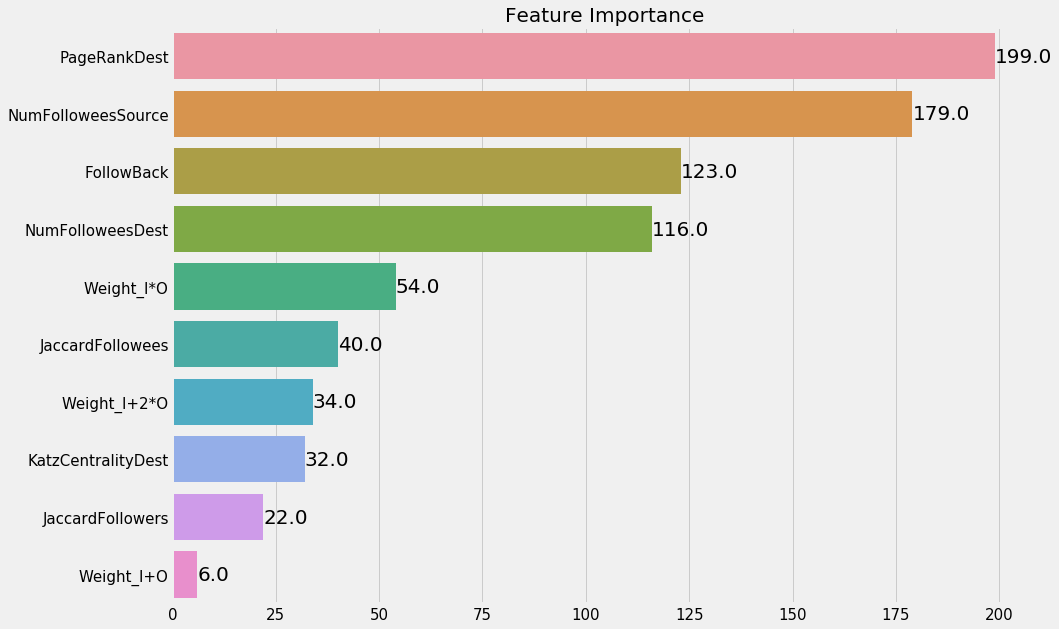

In [160]:
#here, only those feature values will be returned which xgboost has used for splitting. 
#In other words, all of the missing features are never used by xgboost for splitting decision tree.
imp_feats = bst.get_score(importance_type='weight')
imp_feat_df = pd.DataFrame({'Feature_Names':list(imp_feats.keys()), "Importance":list(imp_feats.values())})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(i.get_width()), fontsize=20, color='black')
plt.show()

In [161]:
df = pd.DataFrame({
    'Model': ["Logistic Regression", "SVC", "XGBoost"], 
    'Accuracy': Accuracy_Scores,
    'F1-Score': F1_Score
})
df

,Model,Accuracy,F1-Score
0,Logistic Regression,0.903978,0.904233
1,SVC,0.902756,0.903216
2,XGBoost,0.910189,0.912091


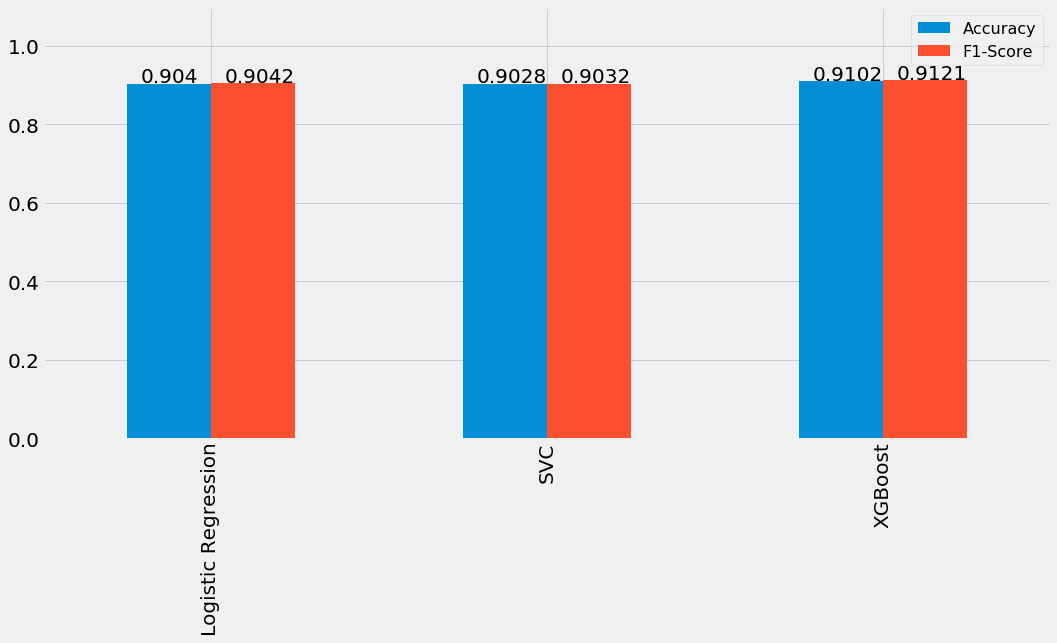

In [180]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,1,1])
df.plot(x = 'Model', y = ['Accuracy', 'F1-Score'], figsize = (14, 6), kind = 'bar', ax = axes, grid = True)
plt.legend(fontsize = 16, loc = 0)
axes.set_xlabel("")
axes.set(ylim = (0,1.1))
axes.tick_params(labelsize = 20)
for i in axes.patches:
    axes.text(i.get_x()+0.04, i.get_height()+0.003, str(round(i.get_height(), 4)), fontsize=20, color='black')
plt.show()

# XGBoost turns out to be the best performing model